In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.keras.utils.set_random_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")
set_seed(42)


Random seed set as 42


In [3]:
_URL = "https://github.com/OROHealth/ace-it/raw/main/data_3class_skin_diseases.zip"
zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="data_3class_skin_diseases.zip", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'data_3class_skin_diseases')

12285702/12285702 [==============================] - 0s 0us/step


In [4]:
classes = ["acne","herpes_simplex","lichen_planus"]

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))               # 80-20 split to train and dev set
  #train, val = images[:13], images[13:16]              # Using this for undersampling the data to 16 images per class
  train,val = images[:num_train], images[num_train:]    # Using the data as is
  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

acne: 40 Images
herpes_simplex: 16 Images
lichen_planus: 46 Images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [7]:
batch_size = 8
IMG_SHAPE = 224 

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

In [9]:
#Data Augmentation
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5,
                    )
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse',
                                                seed=42
                                                )

Found 82 images belonging to 3 classes.


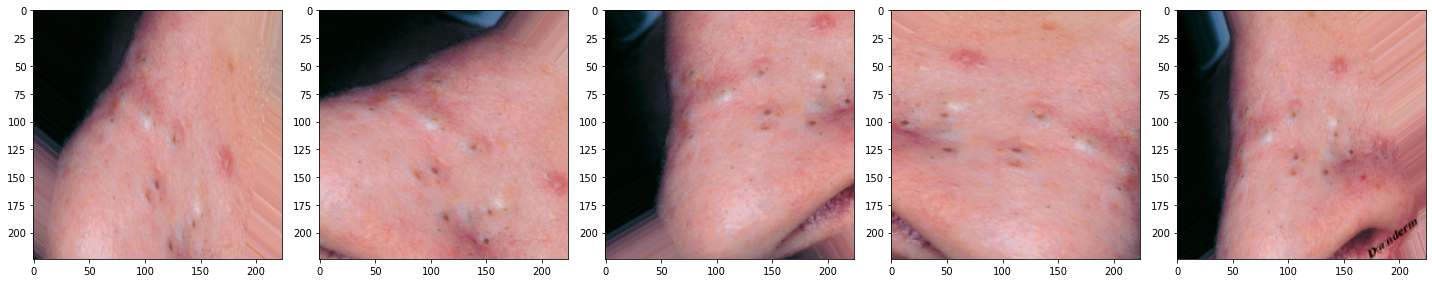

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, 
                                                 directory=val_dir, 
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse',shuffle=False,seed=42)

Found 20 images belonging to 3 classes.


In [12]:
tf.keras.utils.set_random_seed(42)

In [13]:
!unzip mobile_net.zip

Archive:  mobile_net.zip
   creating: content/mobilenet_new/
   creating: content/mobilenet_new/variables/
  inflating: content/mobilenet_new/variables/variables.data-00000-of-00001  
  inflating: content/mobilenet_new/variables/variables.index  
  inflating: content/mobilenet_new/keras_metadata.pb  
   creating: content/mobilenet_new/assets/
  inflating: content/mobilenet_new/saved_model.pb  


In [14]:
mnet_model = tf.keras.models.load_model("/content/content/mobilenet_new", compile=False)

In [15]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(mnet_model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

3/3 [==============================] - 2s 270ms/step
                precision    recall  f1-score   support

          acne       0.89      1.00      0.94         8
herpes_simplex       0.60      1.00      0.75         3
 lichen_planus       1.00      0.67      0.80         9

      accuracy                           0.85        20
     macro avg       0.83      0.89      0.83        20
  weighted avg       0.90      0.85      0.85        20



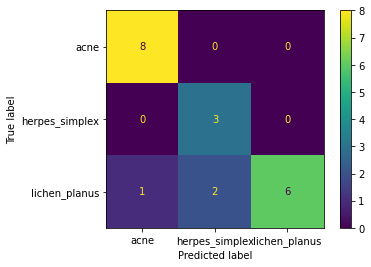

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

In [17]:
#Please use the following for predicting
predictions = np.argmax(mnet_model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)

3/3 [==============================] - 1s 249ms/step


In [18]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(labels,predictions)

0.7899064678139887

In [19]:
from sklearn.preprocessing import label_binarize
bin_labels = label_binarize(labels,classes=[0,1,2])
bin_preds = label_binarize(predictions,classes=[0,1,2])

In [20]:
from sklearn.metrics import auc,roc_curve
classes=[0,1,2]
fpr,tpr,roc_auc= [0]*len(classes),[0]*len(classes),[0]*len(classes)
for i in classes:
  fpr[i],tpr[i],_ = roc_curve(bin_labels[:,i],bin_preds[:,i])
  roc_auc[i] = auc(fpr[i],tpr[i])  

In [21]:
fpr_micro, tpr_micro, _ = roc_curve(bin_labels.ravel(), bin_preds.ravel())
roc_auc_micro = auc(fpr_micro,tpr_micro) 

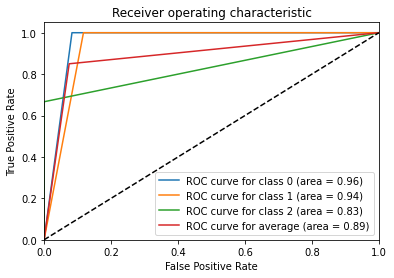

In [22]:
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], label='ROC curve for class 2 (area = %0.2f)' % roc_auc[2])
plt.plot(fpr_micro, tpr_micro, label='ROC curve for average (area = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
import sklearn
sklearn.metrics.f1_score(labels,predictions,average="macro")

0.8303921568627451